In [1]:
# Load packages
using Parameters
using QuantEcon
using Plots
using Format

## Problem 1

Part a

In [2]:
# Define the utility function
function u(c, l, p)
    @unpack β, σ, ν, ϕ = p
    return (c^(1-σ))/(1 - σ) - ϕ * (l^(1+1/ν)/(1 + 1/ν))
end

function update_bellman!(p, V, policy, kgrid, V0, max_idxs)
    @unpack β, δ, σ, ν, α, A, ϕ = p
    n = length(kgrid)
    l_values = LinRange(0, 1, n)  # Adjusting the number of choices for labor supply
    
    vmax = -Inf
    max_idx = 0
    
    for i in 1:n
        k = kgrid[i]

        ki′ = 0
        li′ = 0
        ci′ = 0
        
        for j in 1:n
            k′ = kgrid[j]
            for b in 1:n  # Using num_l_values for the loop
                l = l_values[b]
                c′ = A * k^α * l^(1-α) + (1-δ) * k - k′
                if c′ >= 0
                    v = u(c′, l, p) + β * V0[j]
                    if v >= vmax
                        vmax = v
                        ki′ = j
                        li′ = b
                        ci′ = c′
                        max_idx = i  # Store the index where vmax occurs
                    end
                end
            end
        end

        V[i] = vmax 
        policy[i] = (ki′, li′, ci′)  
    end
    
    # Store the index of vmax
    push!(max_idxs, max_idx)
end

# Implement the VFI algorithm
function solve_vfi(p, kgrid; tol = 1e-6, max_iter = 1000)
    V0 = zeros(length(kgrid))
    V = similar(V0)
    policy = Array{Tuple{Int, Int, Float64}, 1}(undef, length(kgrid))
    max_idxs = []  # Array to store the index of vmax
    
    for iter in 1:max_iter
        update_bellman!(p, V, policy, kgrid, V0, max_idxs)
        error = maximum(abs.(V .- V0))
        if error < tol
            println("Converged after $iter iterations.")
            return V, policy, max_idxs
        end
        copy!(V0, V)
    end
    
    error("Did not converge after $max_iter iterations.")
end

# Parameters
p = (
    β = 0.95,    # Discount Rate
    δ = 0.05,    # Depreciation of capital
    σ = 2.0,     # Uncertainty aversion
    ν = 2.0,     # Risk aversion
    α = 1/3,     # Returns to scale
    A = 1.0,     # Productivity
    ϕ = 1.0     # Disutility from labor

)



(β = 0.95, δ = 0.05, σ = 2.0, ν = 2.0, α = 0.3333333333333333, A = 1.0, ϕ = 1.0)

Converged after 331 iterations.
Converged after 331 iterations.
Converged after 331 iterations.
Converged after 331 iterations.


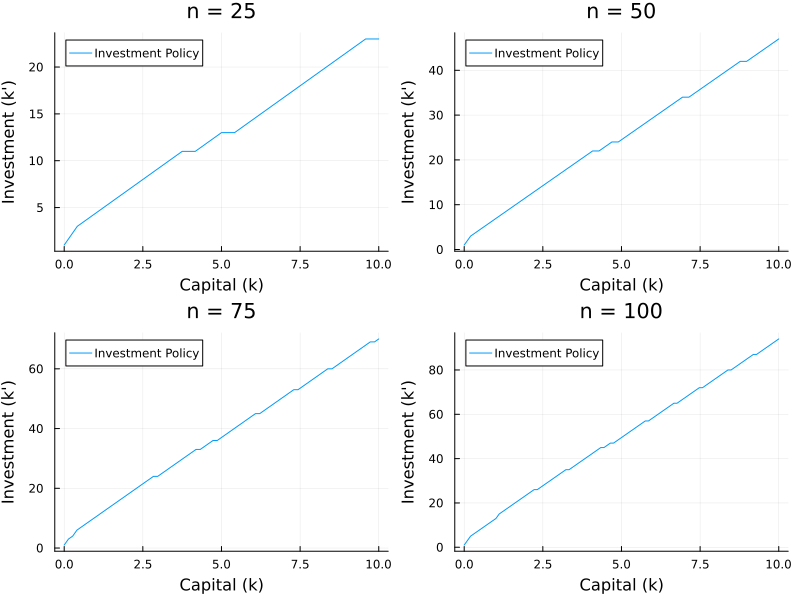

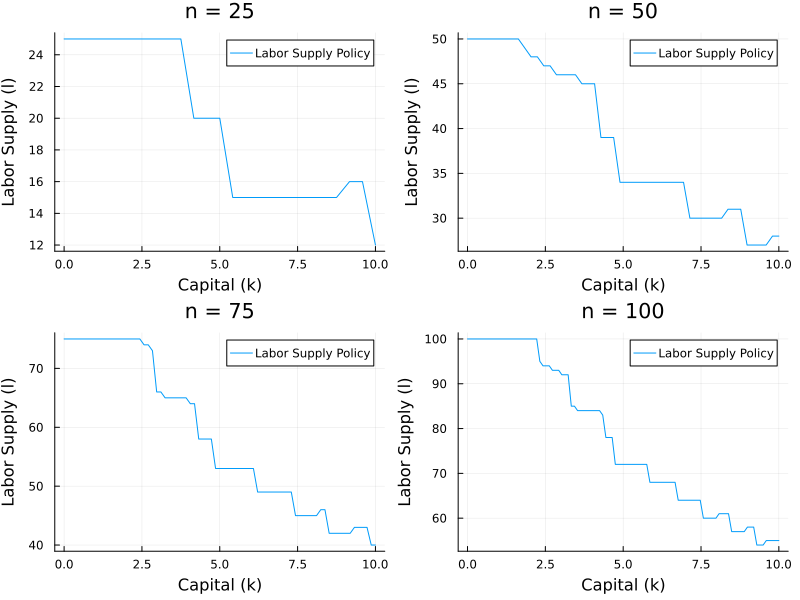

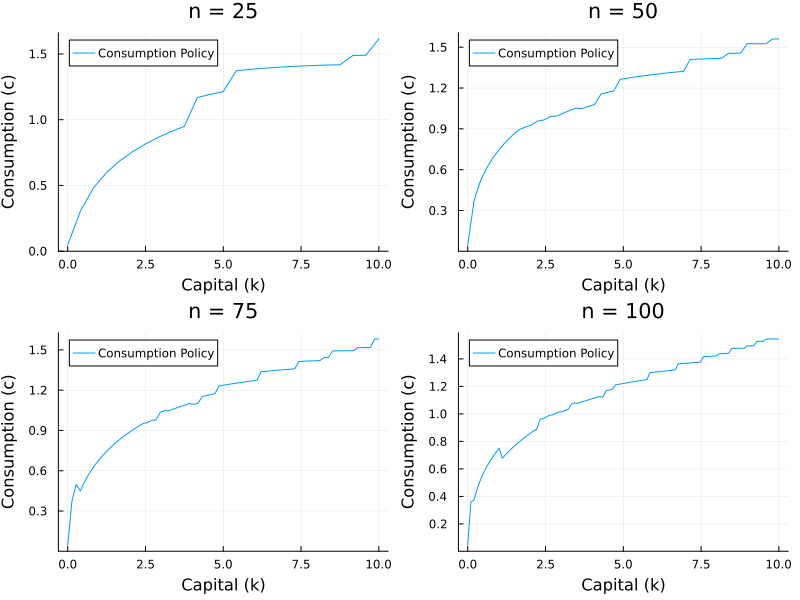

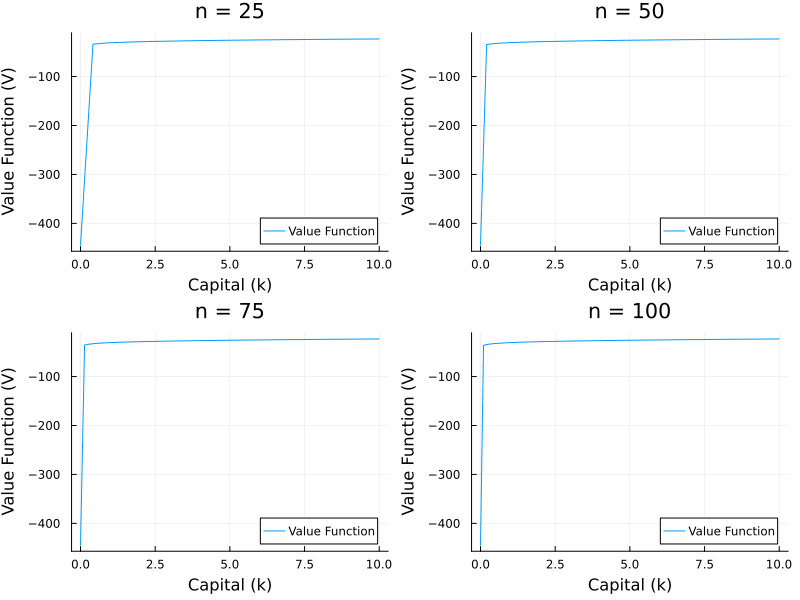

In [3]:
n_values = [25, 50, 75, 100]
plot_titles = ["n = 25", "n = 50", "n = 75", "n = 100"]
plots_investment = []
plots_labour = []
plots_consumption = []
plots_value_function = []

for (i, n) in enumerate(n_values)
    # Define the grid for capital
    kgrid = LinRange(1e-4, 10, n)
    
    # Solve the model
    V, policy, max_idxs = solve_vfi(p, kgrid)
    
    # Extract policy functions
    ki_policy = [p[1] for p in policy]
    li_policy = [p[2] for p in policy]
    ci_policy = [p[3] for p in policy]

    # Get x and y coordinates of maximum values
    max_x_values = kgrid[max_idxs[1]]
    max_y_values = V[max_idxs[1]]
    
    # Plot policy functions with markers at maxima
    p1 = plot(kgrid, ki_policy, xlabel="Capital (k)", ylabel="Investment (k')", label="Investment Policy", title=plot_titles[i])
    push!(plots_investment, p1)
    
    p2 = plot(kgrid, li_policy, xlabel="Capital (k)", ylabel="Labor Supply (l)", label="Labor Supply Policy", title=plot_titles[i])
    push!(plots_labour, p2)
    
    p3 = plot(kgrid, ci_policy, xlabel="Capital (k)", ylabel="Consumption (c)", label="Consumption Policy", title=plot_titles[i])
    push!(plots_consumption, p3)
    
    p4 = plot(kgrid, V, xlabel="Capital (k)", ylabel="Value Function (V)", label="Value Function", title=plot_titles[i])
    push!(plots_value_function, p4)
end

display(plot(plots_investment..., layout=(2, 2), size=(800, 600)))
display(plot(plots_labour..., layout=(2, 2), size=(800, 600)))
display(plot(plots_consumption..., layout=(2, 2), size=(800, 600)))
display(plot(plots_value_function..., layout=(2, 2), size=(800, 600)))

Part b

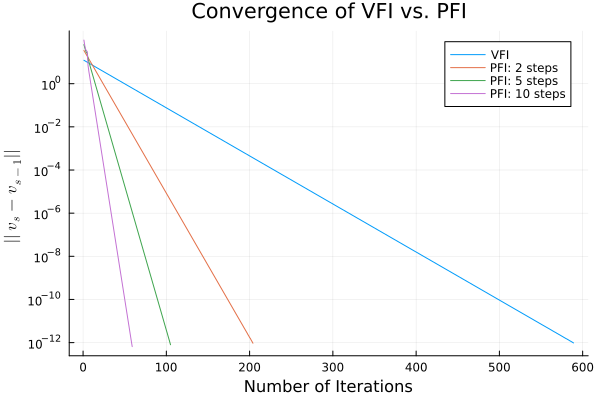

In [4]:
# Parameters
p = (
    β = 0.95,    # Discount Rate
    δ = 0.05,    # Depreciation of capital
    σ = 2.0,     # Uncertainty aversion
    ν = 2.0,     # Risk aversion
    α = 1/3,     # Returns to scale
    A = 1.0,     # Productivity
    ϕ = 1.0     # Disutility from labor

)


# Define the utility function
function u(c, l, p)
    @unpack β, σ, ν, ϕ = p
    result = (c^(1-σ))/(1 - σ) - ϕ * (l^(1+1/ν)/(1 + 1/ν)) 
    return result > 0 ? log(result) : -Inf
end

function update_bellman!(p, V, policy, kgrid, V0)
    @unpack β, δ, σ, ν, α, A, ϕ = p
    n = length(kgrid)
    l_values = LinRange(0, 1, n)  # Adjusting the number of choices for labor supply
    
    l_list = []
    c_list = []
    
    for i in 1:n
        k = kgrid[i]
        vmax = -Inf

        ki′ = 0
        li′ = 0
        ci′ = 0
        
        for j in 1:n
            k′ = kgrid[j]
            for b in 1:n  # Using num_l_values for the loop
                l = l_values[b]
                c = A * k^α * l^(1-α) + (1-δ) * k - k′
                v = u(c, l, p) + β * V0[j]
                if v >= vmax
                    vmax = v
                    ki′ = j
                    li′ = b
                    ci′ = c
                    
                end
            end
        end

        V[i] = vmax 
        policy[i] = ki′  
        push!(l_list, l_values[li′])
        push!(c_list, ci′)
    end

end


function policy_step!(p, V, policy, kgrid, V0)
    @unpack β, δ, σ, ν, α, A, ϕ = p
    n = length(kgrid)
    l_values = LinRange(0, 1, n)  # Adjusting the number of choices for labor supply
    
    for i in 1:n
        vmax = -Inf
        k = kgrid[i]
        k′ = kgrid[policy[i]]
        l′ = 0
        c′ = 0
        
        for j in 1:n
            l = l_values[j]
            c = A * k^α * l^(1-α) + (1-δ) * k - k′
            v = u(c, l, p) + β * V0[policy[i]]
            
            if v >= vmax
                vmax = v
                l′ = l
                c′ = c
            end
        end
        
        V[i] = u(c′, l′, p) + β * V0[policy[i]]
    end
end



function solve_pfi!(p, kgrid, V0; tol = 1e-12, policy_steps = 0, max_iter = 1000)

    V0      = copy(V0)
    V       = similar(V0)
    Vs      = similar(V0)

    policy = zeros(Int, size(V0))
    errors  = Float64[]  
    iter    = 0
    
    while true
        # Update our value function
        iter += 1
        # V0 ~ V_{s-1}(k)
        # V ~ V_{s}^0(k)
        update_bellman!(p, Vs, policy, kgrid, V0)  
        V .= Vs # this is redundant, but makes this code work if policy_steps = 0

        # Iterate on the policy rule 
        for i in 1:policy_steps
            # Vs ~ V_s^{j-1}
            # V  ~ V_s^j
            policy_step!(p, V, policy, kgrid, Vs)
            Vs .= V
        end
        

        # calculate and save the errors
        ϵ = maximum(abs.(V - V0))
        push!(errors, ϵ)
       
        # stop if we've converged
        ϵ < tol         && break
        iter > max_iter  && break 
        V0 .= V
    end

    return (; V, policy, iter, errors)
end

n = 100

solution_vfi = solve_pfi!(p, LinRange(1e-4, 10, n), zeros(n))
@unpack errors = solution_vfi
plt = plot(1:length(errors), errors, yscale = :log10, 
    title  = "Convergence of VFI vs. PFI",
    label  = "VFI",
    xlabel = "Number of Iterations",
    ylabel = raw"$||v_s - v_{s-1}||$",
    yticks = 10.0.^(0:-2:-12)
)

for k in (2, 5, 10)
    solution_pfi = solve_pfi!(p, LinRange(1e-4, 10, n), zeros(n), policy_steps = k)
    @unpack errors = solution_pfi
    plot!(1:length(errors), errors,
        label = "PFI: $k steps" 
    )
end

display(plt)

## Problem 2

part a

In [5]:
u1(c) = (c^(-1))/(-1) 

u1 (generic function with 1 method)

In [6]:
function solve_vfi2!(p, a_grid, V0; tol = 1e-12, maxiter = 1000, debug=false)
    @unpack Ny, ρ, σ_ϵ = p
    V0      = copy(V0)
    V       = zeros(size(V0))
    policy  = zeros(Int, size(V0))
    errors  = Float64[]  
    iter    = 0

    # Discretize the income process
    mc      = rouwenhorst(Ny, ρ, σ_ϵ)
    P       = mc.p'
    y_grid   = mc.state_values
    
    grids   = (; a_grid, y_grid)
    while true
        iter += 1 
        
        # Step 1: Calculate Expectations
        EV = V * P

        # Step 2: Update Bellman Equation
        update_bellman2!(p, V, policy, grids, EV)
        
        # Step 3: Check for convergence 
        ϵ = maximum(abs.(V - V0))
        push!(errors, ϵ)

        ϵ < tol         && break 
        iter >= maxiter && break
        V0 .= V

    end
    return (; V, policy, iter, errors, a_grid, y_grid, P)
end

function update_bellman2!(p, V, policy, grids, EV)
    @unpack a_grid, y_grid = grids 
    @unpack r, β           = p 

    # Check all the dimensions are right
    length(a_grid) == size(V,1) || throw(error("Asset grid size doesn't match V"))
    length(y_grid) == size(V,2) || throw(error("Income grid size doesn't match V"))
    size(EV)       == size(V)   || throw(error("EV and V aren't the same size"))
    
    # Loop over all the indices of V 
    for sub in CartesianIndices(V)
        # Unpack everything 
        ai, yi = sub[1], sub[2]
        a = a_grid[ai]
        y = exp(y_grid[yi])
        
        # Cash on hands
        z  = (1 + r) * a + y
        a′ = a_grid
        c  = z .- a′
        
        # Do a vectorized grid search 
        # Note: the macro views makes this run a bit faster but otherwise doesn't change anything
        vmax, pol = @views findmax(u1.(c) .+ β .* EV[:, yi])
        
        # Store the max values and policies
        V[sub]      = vmax
        policy[sub] = pol
    end
    return 
end


update_bellman2! (generic function with 1 method)

In [7]:

# Set parameters and run code 

Na = 100
Ny = 30
p = (
    β = 0.95,   # Discount factor
    r = 0.04,   # Interest rate
    μ = 0.5,    # Mean of the shock
    ρ = 0.8,    # Persistence of the shock
    σ_ϵ = 0.1,  # Standard deviation of the shock
    Ny
)

V0     = zeros(Na, Ny)
a_grid  = LinRange(1e-4, 201, Na)

# Solve the model 
@time solution = solve_vfi2!(p, a_grid, V0)
@unpack V, policy, errors = solution 

  1.726997 seconds (4.43 M allocations: 1.743 GiB, 3.18% gc time, 42.40% compilation time)


(V = [463.32991799919455 470.4945594115309 … 395.4720134521313 393.6387925265339; 463.3316351812304 470.4962791464869 … 395.47222385462334 393.639031802779; … ; 463.2963910604477 470.46101342202553 … 395.4526741484694 393.61933195616996; 463.29646256440765 470.4610849043315 … 395.4528594766038 393.6194973823945], policy = [19 19 … 52 49; 19 19 … 52 49; … ; 19 19 … 52 49; 19 19 … 52 49], iter = 611, errors = [199.35535103868506, 52.36122611076813, 38.8296268338693, 26.721724994684536, 24.39783869016651, 22.558502046086147, 21.160912219114053, 19.968604767091023, 18.872634498764597, 17.87756856794448  …  1.2505552149377763e-12, 1.3642420526593924e-12, 1.1368683772161603e-12, 1.2505552149377763e-12, 1.1368683772161603e-12, 1.0800249583553523e-12, 1.0800249583553523e-12, 1.0231815394945443e-12, 1.0231815394945443e-12, 9.094947017729282e-13], a_grid = LinRange{Float64}(0.0001, 201.0, 100), y_grid = -0.8975274678557509:0.0618984460590173:0.8975274678557509, P = [0.04710128697246249 0.0052334

#### For Na = 100 and Ny = 30 any value of a_grid ≤ 200 causes the value of V to suffer from the Runge phenomenon

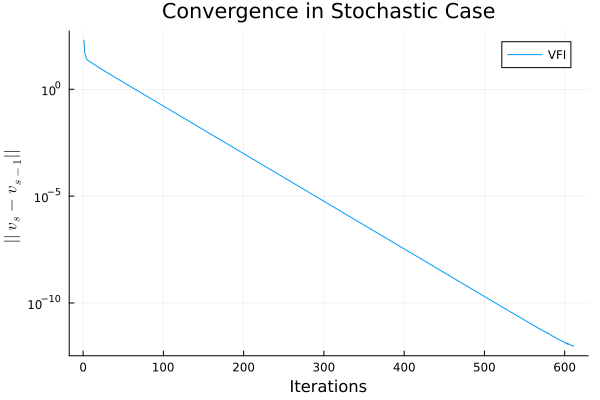

In [8]:
plot(1:length(errors), errors, 
    yscale = :log10,
    title  = "Convergence in Stochastic Case",
    xlabel = "Iterations",
    ylabel = raw"$||v_s - v_{s-1}||$",
    label  = "VFI",
    # yticks = 10.0.^(0:-2:-10)
)

#### Plotting the Policy Funcitons 


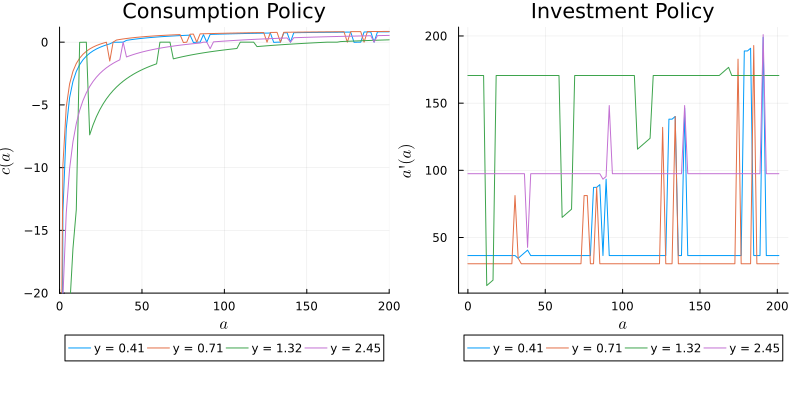

In [9]:
@unpack r = p
@unpack a_grid, y_grid = solution
a′ = a_grid[solution.policy]
z  = (1 + r) .* a_grid .+ exp.(y_grid')

# Define consumption
c  = z .- a′

# Consumption/investment share 
cs = c./z
as = a′./z

## First let's plot consumption policy for a variety of y values 
yVals = [1, 10, 20, 30]
p1 = plot(legend=:outerbottom, legend_column = -1)
for yi in yVals
    plot!(a_grid, cs[:, yi], label = format("y = {:.2f}", exp(y_grid[yi])))
end
title!("Consumption Policy")
ylabel!(raw"$c(a)$")
xlabel!(raw"$a$")
ylims!(-20, 1.2)  # Set custom y-axis range
xlims!(0, 200)   # Set custom x-axis range

## Next let's plot investment policy for the same y values
p2 = plot(legend=:outerbottom, legend_column = -1)
for yi in yVals
    plot!(a_grid, a′[:, yi], label = format("y = {:.2f}", exp(y_grid[yi])))
end
title!("Investment Policy")
ylabel!(raw"$a'(a)$")
xlabel!(raw"$a$")

plt = plot(p1, p2, size = (800, 400), layout = (1,2))

#### The graph of Consumption policy displays values below zero. This is likely wrong. 

part b